In [1]:
from constants import ERA5_BEST_INFERENCE_WANDB_RUN_IDS
from utils import wandb_to_beaker_result, beaker_to_xarray
import xarray as xr
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)
plt.rcParams['figure.dpi'] = 300

In [2]:
wandb_id = ERA5_BEST_INFERENCE_WANDB_RUN_IDS["81yr-IC2"]
beaker_dataset_id = wandb_to_beaker_result("ace", wandb_id)

### Load datasets (about 750MB each)

In [3]:
ds_pred = beaker_to_xarray(beaker_dataset_id, "monthly_mean_predictions.nc")
ds_target = beaker_to_xarray(beaker_dataset_id, "monthly_mean_target.nc")
ds_pred = ds_pred.isel(time=slice(None, -2)).isel(sample=0)
ds_target = ds_target.isel(time=slice(None, -2)).isel(sample=0)
# since only have one ensemble member, can use richer valid_time as time
# instead of requiring scalar time
ds_pred['time'] = ds_pred['valid_time']
ds_target['time'] = ds_target['valid_time']

Output()

Output()

In [12]:
ds = xr.concat(
    [ds_target.assign_coords(source="ERA5"), ds_pred.assign_coords(source="ACE2-ERA5")],
    dim="source"
)

In [13]:
ds_zm = ds.mean(dim='lon')

In [14]:
ds_zm

<xarray.Dataset> Size: 4MB
Dimensions:            (source: 2, time: 973, lat: 180)
Coordinates:
  * time               (time) datetime64[ns] 8kB 1940-01-15 ... 2021-01-15
    init_time          datetime64[ns] 8B 1940-01-01
    valid_time         (time) datetime64[ns] 8kB 1940-01-15 ... 2021-01-15
  * lat                (lat) float32 720B -89.24 -88.25 -87.25 ... 88.25 89.24
  * source             (source) <U9 72B 'ERA5' 'ACE2-ERA5'
Data variables:
    counts             (source, time) int64 16kB 113 116 124 120 ... 120 124 8
    eastward_wind_0    (source, time, lat) float32 1MB -0.1298 -0.3102 ... 1.095
    air_temperature_7  (source, time, lat) float32 1MB 246.2 246.6 ... 246.0
    total_water_path   (source, time, lat) float32 1MB 0.9653 0.9753 ... 1.428

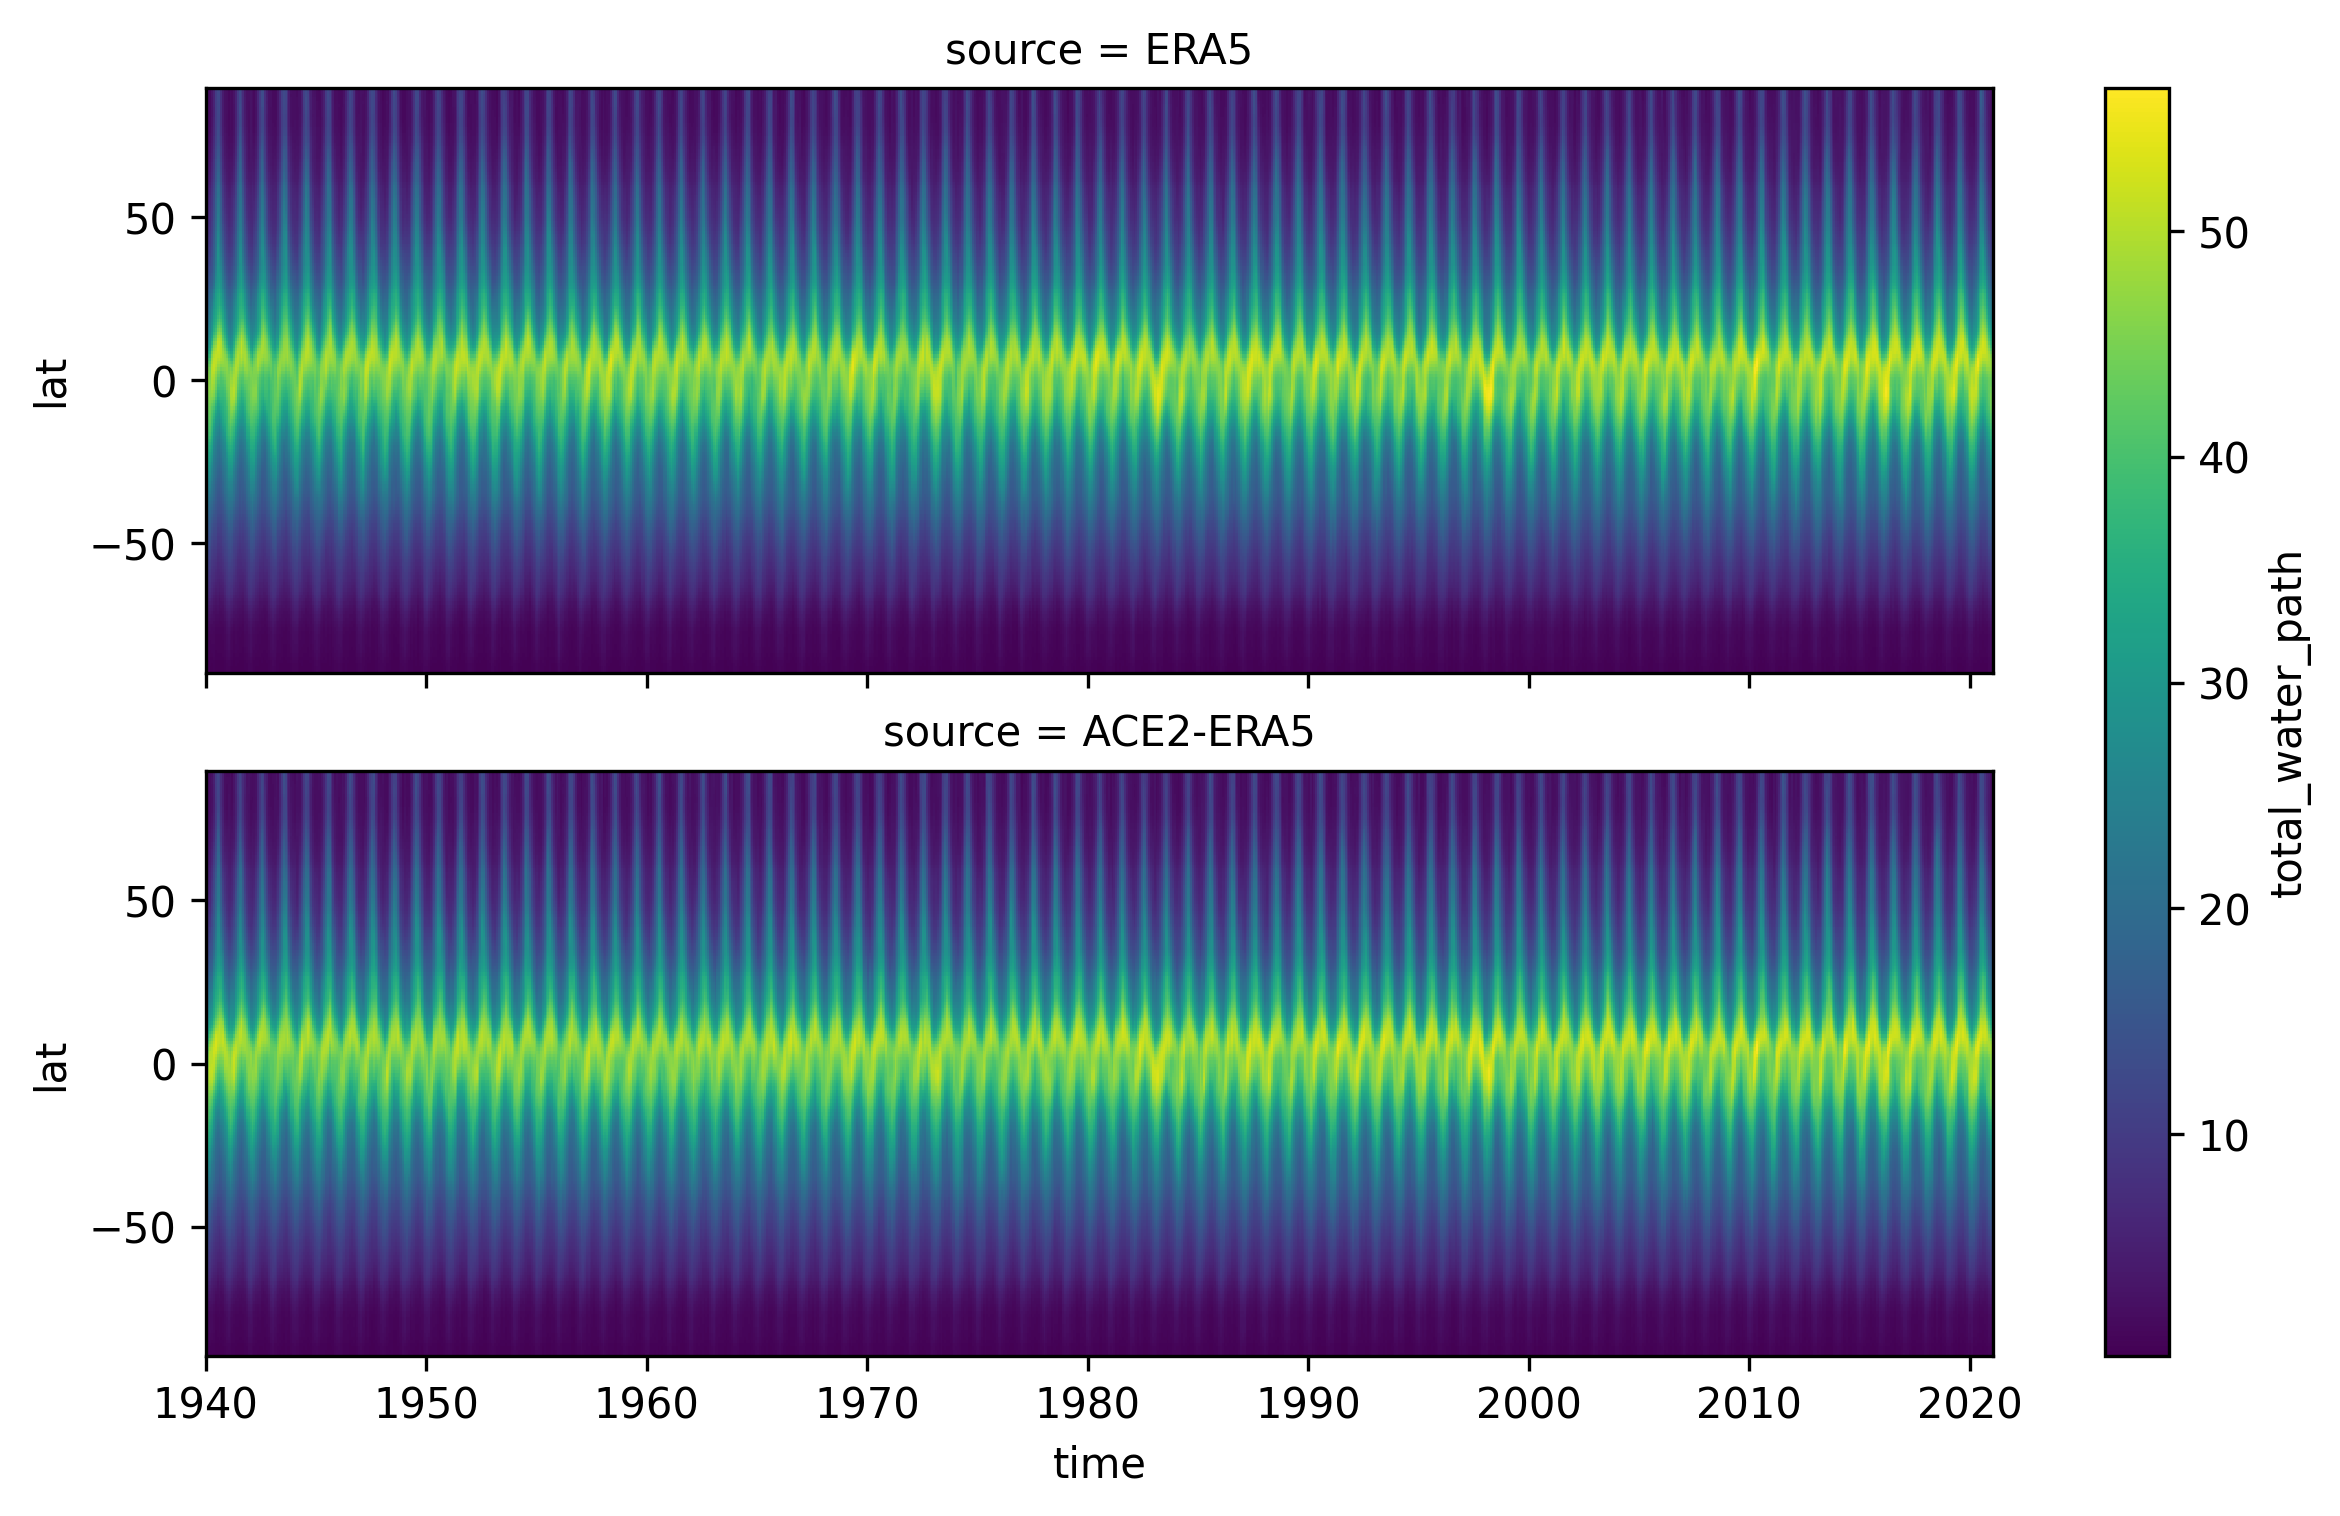

In [15]:
fg = ds_zm.total_water_path.plot(row='source', x='time')
fg.fig.set_size_inches(10, 5)

Text(0.5, 1.0, 'Mean 2001 - 2010')

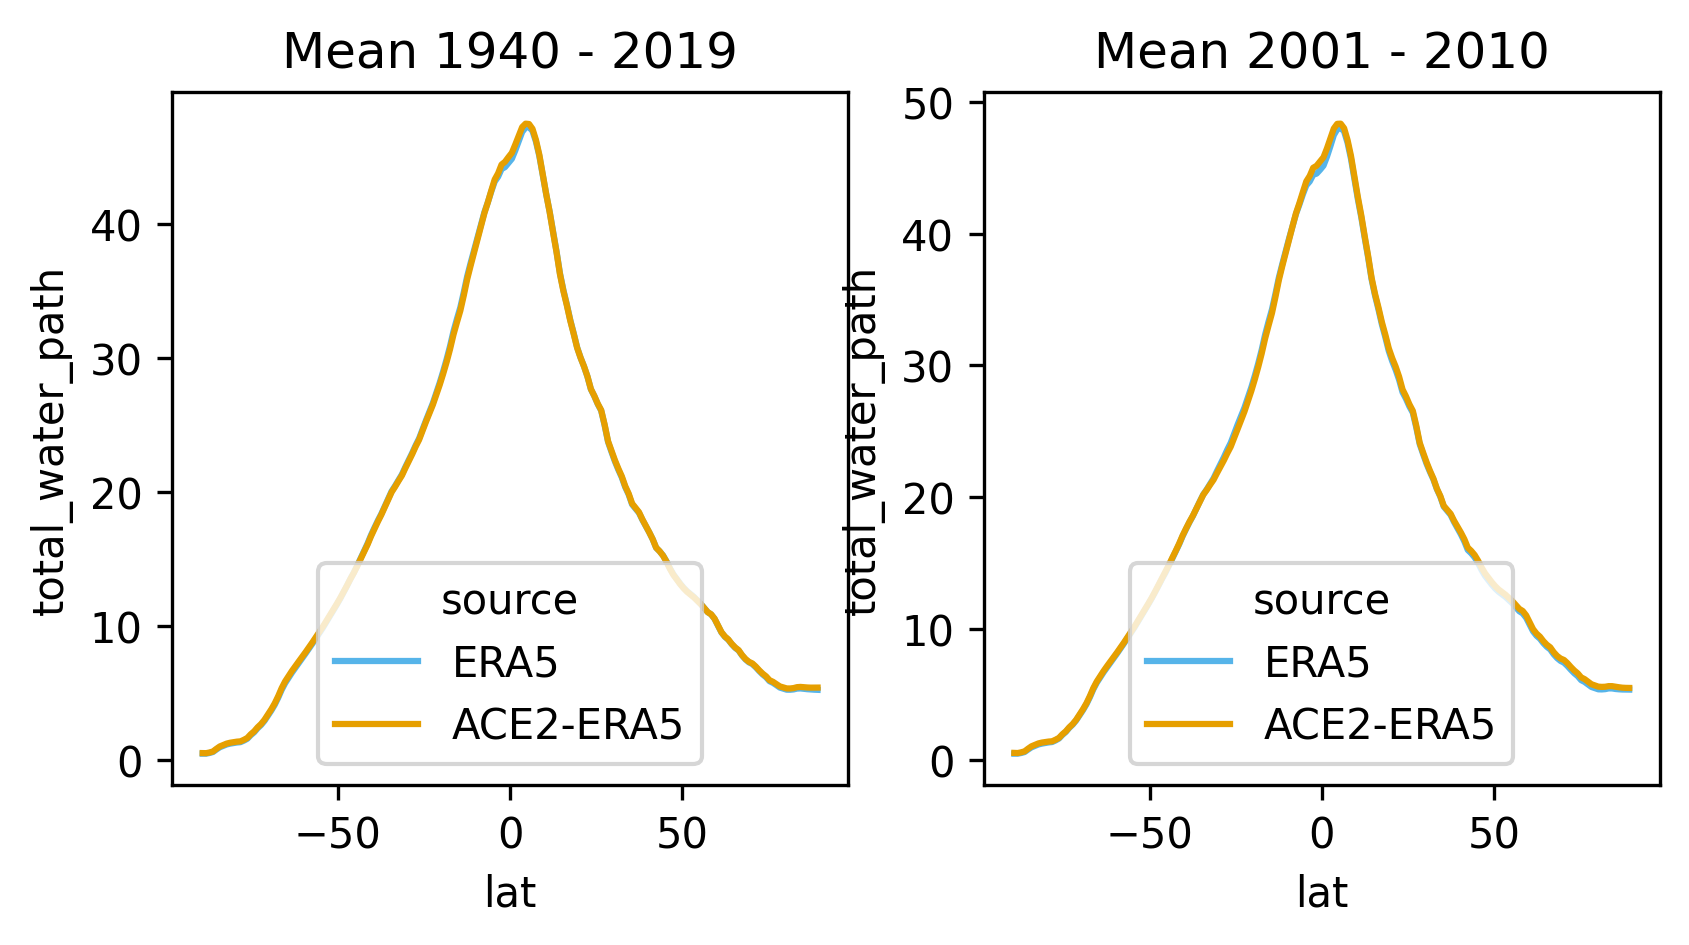

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(6.4, 3))
ds_zm.total_water_path.mean('time').plot(ax=axes[0], hue='source')
ds_zm.total_water_path.sel(time=slice('2001', '2010')).mean('time').plot(ax=axes[1], hue='source')
axes[0].set_title('Mean 1940 - 2019')
axes[1].set_title('Mean 2001 - 2010')

Text(0.5, 1.0, 'Level-0 zonal mean zonal wind, 5S - 5N')

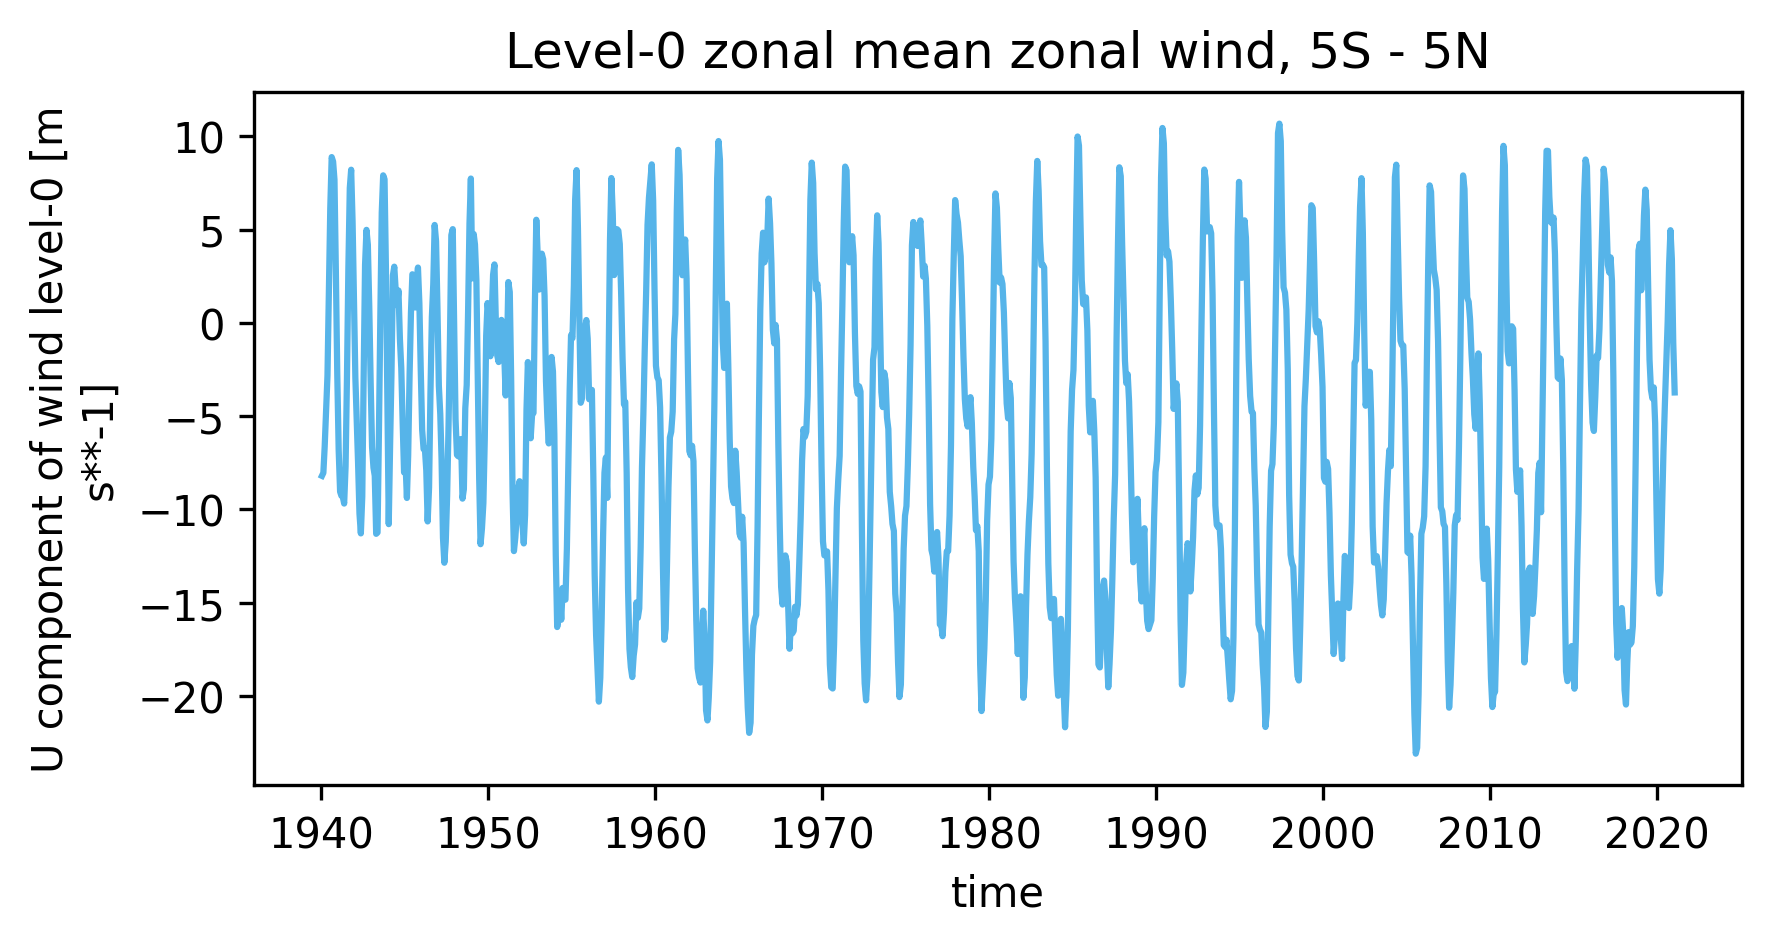

In [19]:
qbo = ds_zm.eastward_wind_0.sel(lat=slice(-5, 5)).mean('lat')
fig, ax = plt.subplots(1, 1, figsize=(6.4, 3))
qbo.sel(source='ERA5').plot(ax=ax, x='time')
ax.set_title('Level-0 zonal mean zonal wind, 5S - 5N')

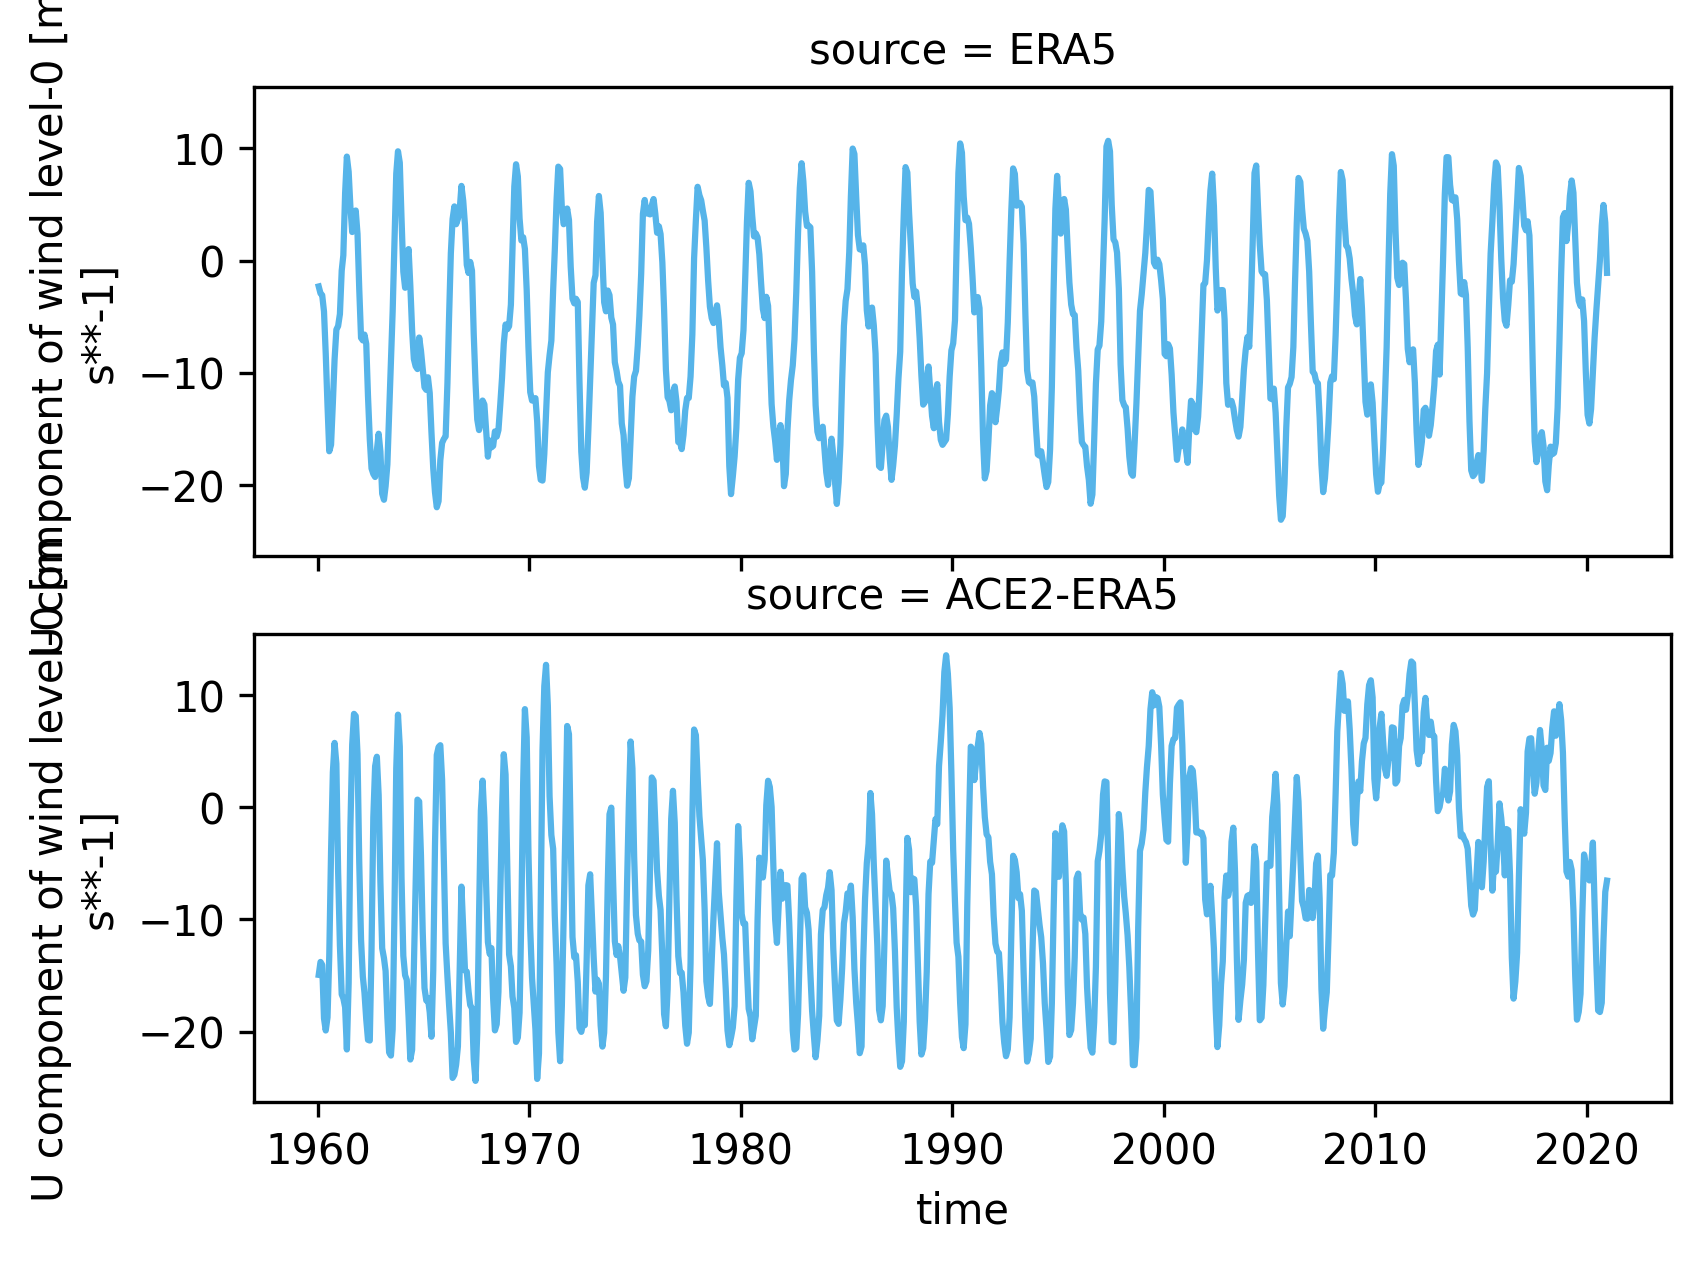

In [20]:
fg = qbo.sel(time=slice('1960', '2020')).plot(row='source', x='time')
fg.fig.set_size_inches(6.4, 4)

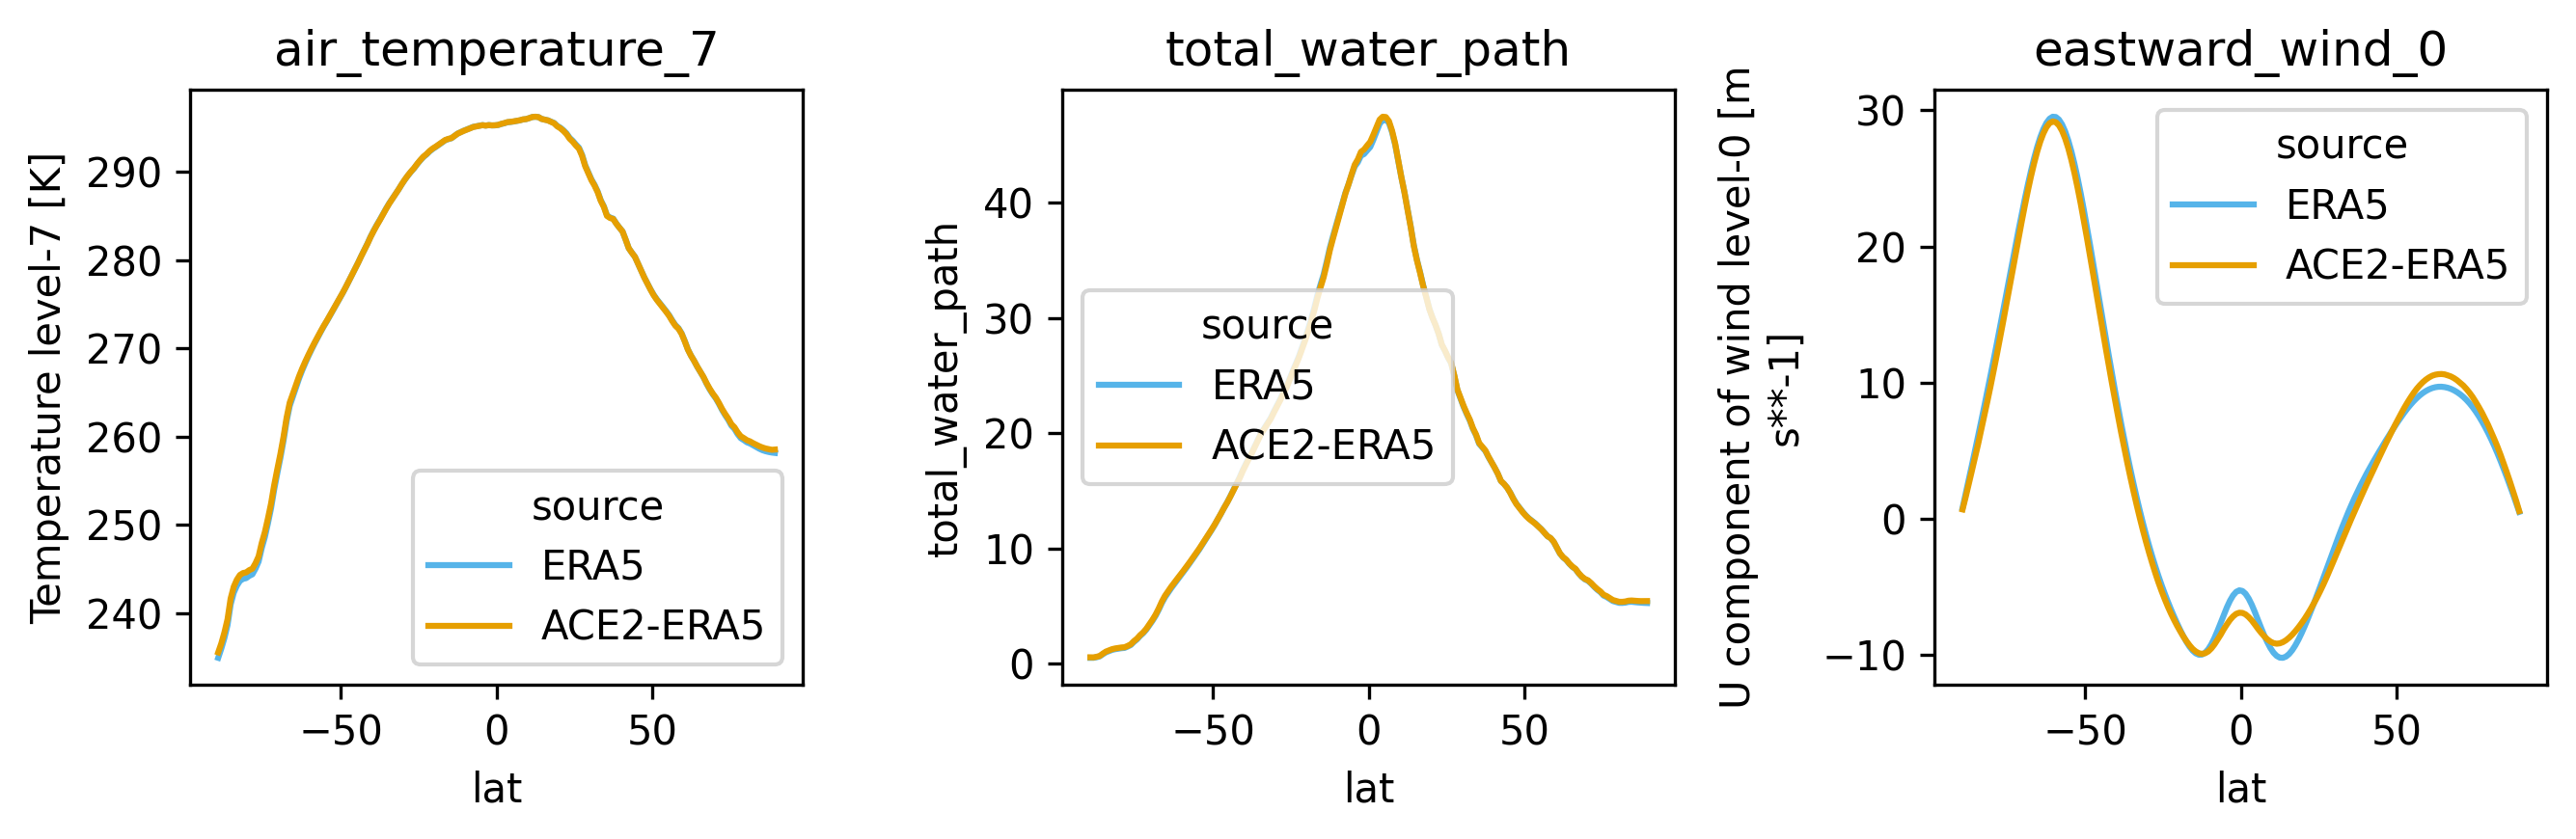

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
names = ['air_temperature_7', 'total_water_path', 'eastward_wind_0']
for i, name in enumerate(names):
    ds_zm[name].mean('time').plot(ax=axes[i], hue='source')
    axes[i].set_title(name)
fig.tight_layout()